In [610]:
import pandas as pd
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from scipy.stats import randint, uniform
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV


In [611]:
path = '../resources/examen_final/wine_quality.csv'
data_original = pd.read_csv(path, sep=',', )
data_copy = data_original.copy().drop('Unnamed: 0', axis=1)

In [612]:
data_copy.head(10)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


In [613]:
print(f'Valores Nulos: \n{data_copy.isnull().sum()} ')

Valores Nulos: 
fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64 


In [614]:
print(f'Tamaño Datos:  \n{data_copy.dtypes}')
print('-----------------')
print(f'Uso de memoria: \n{data_copy.memory_usage(deep= True)}')

Tamaño Datos:  
fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object
-----------------
Uso de memoria: 
Index                     128
fixed_acidity           51976
volatile_acidity        51976
citric_acid             51976
residual_sugar          51976
chlorides               51976
free_sulfur_dioxide     51976
total_sulfur_dioxide    51976
density                 51976
pH                      51976
sulphates               51976
alcohol                 51976
quality                 51976
dtype: int64


In [615]:
print(data_copy.max())

fixed_acidity            15.90000
volatile_acidity          1.58000
citric_acid               1.66000
residual_sugar           65.80000
chlorides                 0.61100
free_sulfur_dioxide     289.00000
total_sulfur_dioxide    440.00000
density                   1.03898
pH                        4.01000
sulphates                 2.00000
alcohol                  14.90000
quality                   9.00000
dtype: float64


In [616]:
data_copy_resized = data_copy.astype({
                'fixed_acidity': 'float32',
                'volatile_acidity': 'float32',
                'citric_acid': 'float32',
                'residual_sugar': 'float32',
                'chlorides': 'float32',
                'free_sulfur_dioxide': 'float32',
                'total_sulfur_dioxide': 'float32',
                'density': 'float32',
                'pH': 'float32',
                'sulphates': 'float32',
                'alcohol': 'float32',
                'quality': 'int8'})

tabla = list(zip(data_copy.columns,data_copy.memory_usage(deep= True), data_copy_resized.memory_usage(deep = True)))
tabla = pd.DataFrame(tabla, columns=['columnas', 'peso original en memoria', 'peso ajustado en memoria'])
print(tabla)

                columnas  peso original en memoria  peso ajustado en memoria
0          fixed_acidity                       128                       128
1       volatile_acidity                     51976                     25988
2            citric_acid                     51976                     25988
3         residual_sugar                     51976                     25988
4              chlorides                     51976                     25988
5    free_sulfur_dioxide                     51976                     25988
6   total_sulfur_dioxide                     51976                     25988
7                density                     51976                     25988
8                     pH                     51976                     25988
9              sulphates                     51976                     25988
10               alcohol                     51976                     25988
11               quality                     51976                     25988

In [617]:
print(f'Dimensionalidad Original: {data_copy.shape} ')
print('-----------------')
print(f'Datos duplicados: {data_copy_resized.duplicated().sum()}')

duplicates = data_copy_resized[data_copy_resized.duplicated(keep=False)]  # keep=False mantiene todas las copias
print(f"Total de filas duplicadas: {len(duplicates)}")
different_labels = duplicates.groupby(data_copy_resized.columns[:-1].tolist())["quality"].nunique()

# Filtramos los casos donde haya más de una etiqueta distinta
conflicting_duplicates = different_labels[different_labels > 1]
print(f"Total de duplicados con etiquetas diferentes: {len(conflicting_duplicates)}")

data_copy_resized = data_copy_resized.drop_duplicates()
print(f'----------'
      f'\nDatos duplicados finales: {data_copy_resized.duplicated().sum()}'
      f'\n----------'
      f'\nDimensiones finales: {data_copy_resized.shape}')


Dimensionalidad Original: (6497, 12) 
-----------------
Datos duplicados: 1179
Total de filas duplicadas: 2172
Total de duplicados con etiquetas diferentes: 0
----------
Datos duplicados finales: 0
----------
Dimensiones finales: (5318, 12)


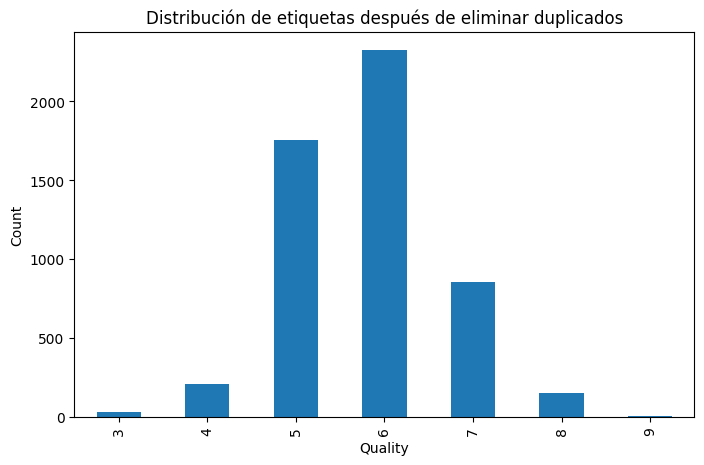

Total de registros por clase:
quality
3      30
4     206
5    1751
6    2323
7     855
8     148
9       5
Name: count, dtype: int64


In [618]:
plt.figure(figsize=(8, 5))
data_copy_resized['quality'].value_counts().sort_index().plot(kind='bar')
plt.xlabel("Quality")
plt.ylabel("Count")
plt.title("Distribución de etiquetas después de eliminar duplicados")
plt.show()

class_counts = data_copy_resized["quality"].value_counts().sort_index() 
# Mostrar el conteo en la consola
print("Total de registros por clase:")
print(class_counts)

In [619]:
X = data_copy_resized.drop(columns = ["quality"])
y = data_copy_resized["quality"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify= y, random_state= 42)

In [620]:
smote = SMOTE(sampling_strategy= "auto", k_neighbors= 3, random_state= 42)
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)

In [621]:
#HIPERPARAMETROS PARA BUSQUEDA
param_list_rf = {
    "model__n_estimators": randint(50, 200),
    "model__max_depth": randint(3, 20),
    "model__class_weight": ["balanced", None]
}

param_list_xbg = {
    "model__n_estimators": randint(50, 200),
    "model__max_depth": randint(3, 20),
    "model__learning_rate": uniform(0.01, 0.3),
}

param_list_svm = {
    "model__C": uniform(0.1, 10),
    "model__gamma": ["scale", "auto"],
    "model__class_weight": ["balanced", None]
}

In [622]:
#DEFINICION DE PIPELINES PARA BUSQUEDA
rf_pipeline = Pipeline([
    ("model", RandomForestClassifier(random_state = 42))
])

xgb_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", XGBClassifier(eval_metric = "mlogloss"))
])

svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC(kernel= "rbf", probability= True))
])

In [623]:
import numpy as np


def search_best_params(pipeline, param_list, X, y, name):
    if (name in["XGBoost Sampled", "XGBoost" ]):
        unique_classes = np.sort(y.unique())  # Obtener clases únicas ordenadas
        class_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_classes)}
        y = y.map(class_mapping)
     
    search = RandomizedSearchCV(pipeline, param_list, n_iter = 10, cv = 3, scoring="accuracy", random_state=42, n_jobs= -1)
    search.fit(X,y)
    print(f"\nMejores hiperparametros para {name}:")
    print(search.best_params_)
    print(f"Mejor Accuracy: {search.best_score_:.4f}")
    return search.best_estimator_, class_mapping if name in ["XGBoost Sampled", "XGBoost"] else None

In [624]:
print("\n Evaluando modelos en datos Sampled: ")
best_rf_resampled = search_best_params(rf_pipeline, param_list_rf, X_train_sampled, y_train_sampled, "Random Forest Sampled")
best_xgb_resampled = search_best_params(xgb_pipeline, param_list_xbg, X_train_sampled, y_train_sampled, "XGBoost Sampled")
best_svm_resampled = search_best_params(svm_pipeline, param_list_svm, X_train_sampled, y_train_sampled, "SVM Sampled")



 Evaluando modelos en datos Sampled: 

Mejores hiperparametros para Random Forest Sampled:
{'model__class_weight': 'balanced', 'model__max_depth': 17, 'model__n_estimators': 156}
Mejor Accuracy: 0.8411

Mejores hiperparametros para XGBoost Sampled:
{'model__learning_rate': np.float64(0.24390730008183079), 'model__max_depth': 9, 'model__n_estimators': 171}
Mejor Accuracy: 0.8445

Mejores hiperparametros para SVM Sampled:
{'model__C': np.float64(8.424426408004217), 'model__class_weight': None, 'model__gamma': 'auto'}
Mejor Accuracy: 0.7673


In [625]:
print("\n Evaluando modelos en datos sin Sampled: ")
best_rf = search_best_params(rf_pipeline, param_list_rf, X_train, y_train, "Random Forest ")
best_xgb = search_best_params(xgb_pipeline, param_list_xbg, X_train, y_train, "XGBoost")
best_svm= search_best_params(svm_pipeline, param_list_svm, X_train, y_train, "SVM ")


 Evaluando modelos en datos sin Sampled: 

Mejores hiperparametros para Random Forest :
{'model__class_weight': 'balanced', 'model__max_depth': 17, 'model__n_estimators': 156}
Mejor Accuracy: 0.5752

Mejores hiperparametros para XGBoost:
{'model__learning_rate': np.float64(0.11011258334170654), 'model__max_depth': 10, 'model__n_estimators': 180}
Mejor Accuracy: 0.5548

Mejores hiperparametros para SVM :
{'model__C': np.float64(3.1424224295953773), 'model__class_weight': None, 'model__gamma': 'scale'}
Mejor Accuracy: 0.5649
